In [1]:
import mailbox
import pandas as pd
import spacy
import re
from spacy import displacy
import en_core_web_sm
from datetime import datetime
import IPython
import matplotlib.pyplot as plt
import seaborn as sns

Appended Donation and Nodonation files manually and created a Final file for each party.

Create a single dataframe by appending all the 4 final files with body of the email, date of the email sent(to understand the frequency of each party's emails) and the name of the sending party as columns.

In [2]:
mbox_file1 = "PE-Liberal-Final.mbox"
mbox_file2 = "PE-Conservatives-Final.mbox"
mbox_file3 = "PE-NDP-Final.mbox"
mbox_file4 = "PE-GreenParty-Final.mbox"


x=[]
df = pd.DataFrame(columns=['body', 'date'])


def test(input_file):


  for part in input_file.walk():  
    if part['From']:
      #party = part['From'].split('.', -2)[-2]
      pol_party=re.split(r"[^a-zA-Z0-9\s]", part['From'])


      #party = pa.split('.', 2)[-2]

    if ('liberal' in pol_party) or ('nbliberal' in pol_party) or ('libéral' in pol_party):
      pol_party='Liberal Party of Canada'

    if ('conservative' in pol_party) or ('conservateur' in pol_party):
      pol_party='Conservative Party of Canada'
    
    if ('ndp' in pol_party )or ('du ndp' in pol_party )or ('npd' in pol_party):
      pol_party='NDP Party of Canada'
    

    if ('greenparty' in pol_party) or ('fête verte' in pol_party) or ('partivert' in pol_party):
      pol_party='Green Party of Canada'
      
    if part['Date']:

      dt=part['Date'].rsplit(' ', 1)[0]
      date_time_obj = datetime.strptime(dt, '%a, %d %b %Y %H:%M:%S').strftime('%d/%m/%Y')
  
    if input_file.is_multipart():
    
      for part in input_file.walk():
        if part['Date']:
            dt = part['Date'].rsplit(' ', 1)[0]
            date_time_obj = datetime.strptime(dt, '%a, %d %b %Y %H:%M:%S').strftime('%d/%m/%Y')
        ctype = part.get_content_type()
        cdispo = str(part.get('Content-Disposition'))
        # skip any text/plain (txt) attachments
        if ctype == 'text/plain' and 'attachment' not in cdispo:
            body = part.get_payload(decode=True)  # decode
            strtext = body.decode()
            break
        # not multipart - i.e. plain text, no attachments, keeping fingers crossed
    else:
        body = input_file.get_payload(decode=True)
        strtext = body.decode()
        dt = input_file['Date'].rsplit(' ', 1)[0]
        date_time_obj = datetime.strptime(dt, '%a, %d %b %Y %H:%M:%S').strftime('%d/%m/%Y')

  return strtext, date_time_obj,pol_party


mbox = mailbox.mbox(mbox_file1)
mbox2 = mailbox.mbox(mbox_file2)
mbox3 = mailbox.mbox(mbox_file3)
mbox4 = mailbox.mbox(mbox_file4)



for i in mbox:
  b,date_time,party=test(i)
  df = df.append({'body':b, 'date': date_time,'party':party}, ignore_index=True)


print('Liberal',df.shape)

for i in mbox2:
  b,date_time,party=test(i)
  df = df.append({'body':b, 'date': date_time,'party':party}, ignore_index=True)

print('Conservatives',df.shape)



for i in mbox3:
  b,date_time,party=test(i)
  df = df.append({'body':b, 'date': date_time,'party':party}, ignore_index=True)

print('NDP',df.shape)



for i in mbox4:
  b,date_time,party=test(i)
  df = df.append({'body':b, 'date': date_time,'party':party}, ignore_index=True)

print('Green Party',df.shape)


Liberal (1240, 3)
Conservatives (2607, 3)
NDP (4362, 3)
Green Party (4714, 3)


Exporting the final dataframe with all the data to csv to get a better view of the data

In [ ]:
df.to_csv('tt.csv')

Creating a function to extract all the people's names in the email by passing a string along with the visualizations



In [3]:
nlp=spacy.load('en_core_web_sm')

def get_names(input):

  y = []
  dt=[]
  doc = nlp(input)
  displacy.render(doc, jupyter=True, style='ent')
  displacy.render(doc, style='dep', jupyter = True, options = {'distance': 120})
  for i in doc.ents:
    if i.label_=='PERSON':
      if i.text not in y and not re.findall(r'www|http|https|street',i.text.lower()) :
        y.append(i.text)
  
  return y

t=df['body']

s=t[12].split()
j=" ".join(s)

print(get_names(j))

['Michael', 'Anna Gainey']


Converting the date in the dataframe to the date format

In [ ]:
df['date']=pd.to_datetime(df['date'])
df=df.sort_values(by='date')

Converting the data to weekly data by resampling the data for all the 4 parties.

Added a new column called count to count the frequency of emails in each week for particular a party

In [ ]:
df['count']=1
df2=df.set_index('date').groupby('party')['count'].resample('W').count()
df2=df2.reset_index()
df2

,party,date,count
0,Conservative Party of Canada,2014-02-16,2
1,Conservative Party of Canada,2014-02-23,0
2,Conservative Party of Canada,2014-03-02,0
3,Conservative Party of Canada,2014-03-09,0
4,Conservative Party of Canada,2014-03-16,3
...,...,...,...
800,NDP Party of Canada,2017-11-12,2
801,NDP Party of Canada,2017-11-19,0
802,NDP Party of Canada,2017-11-26,0
803,NDP Party of Canada,2017-12-03,2


Checking the unique values in the party column

In [ ]:
df2['party'].unique()

array(['Conservative Party of Canada', 'Green Party of Canada',
       'Liberal Party of Canada', 'NDP Party of Canada'], dtype=object)

Visualizing the weekly time frequency by splitting with party

party
Conservative Party of Canada    AxesSubplot(0.125,0.125;0.775x0.755)
Green Party of Canada           AxesSubplot(0.125,0.125;0.775x0.755)
Liberal Party of Canada         AxesSubplot(0.125,0.125;0.775x0.755)
NDP Party of Canada             AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

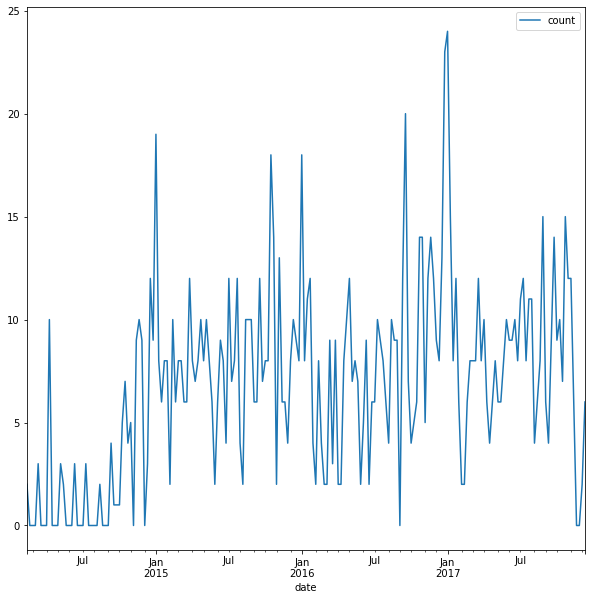

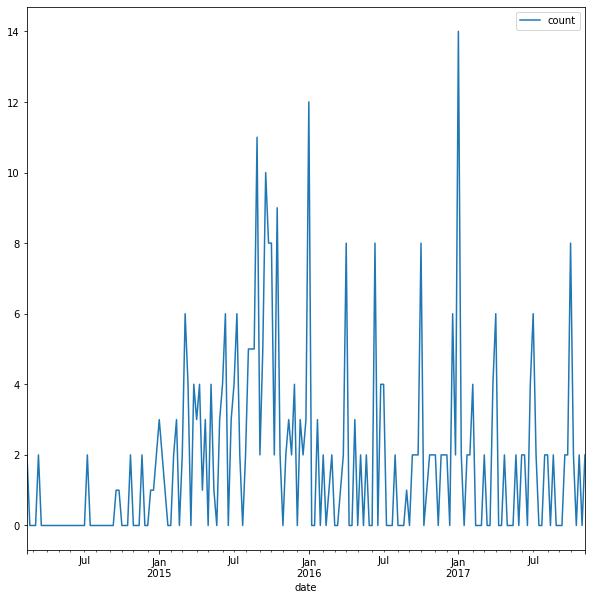

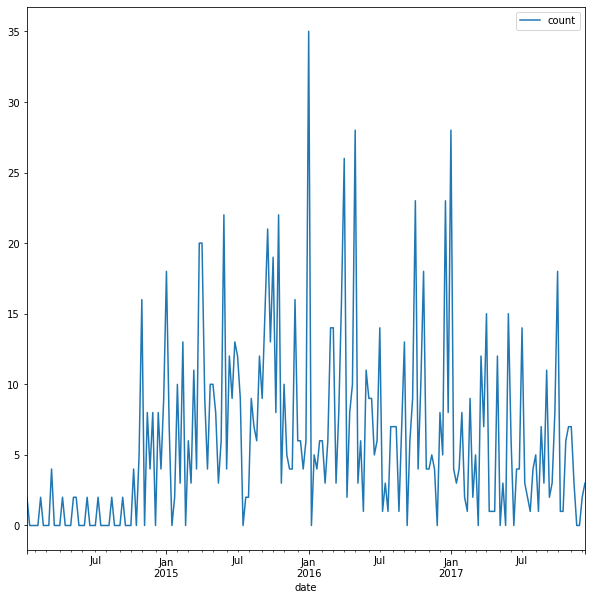

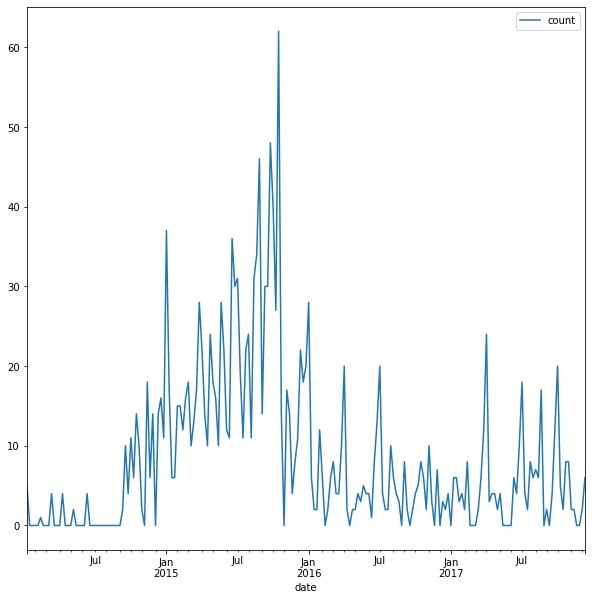

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df2.set_index('date').groupby('party').plot(figsize=(10,10))



Creating a better visualization for weekly data of each party

Conservative Party of Canada


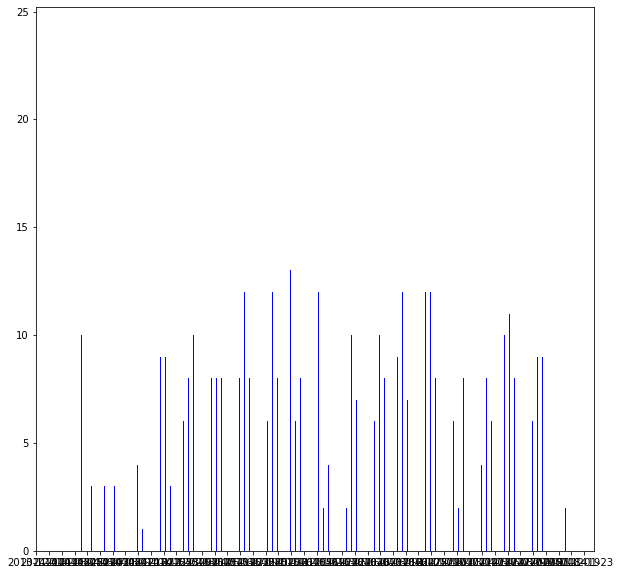

Green Party of Canada


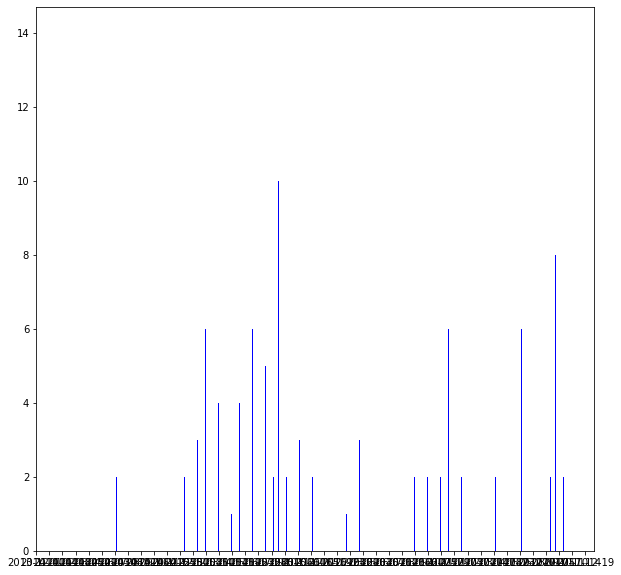

Liberal Party of Canada


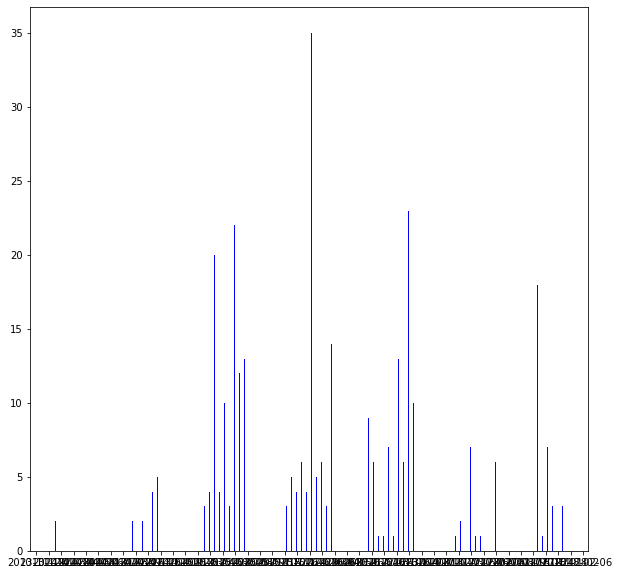

NDP Party of Canada


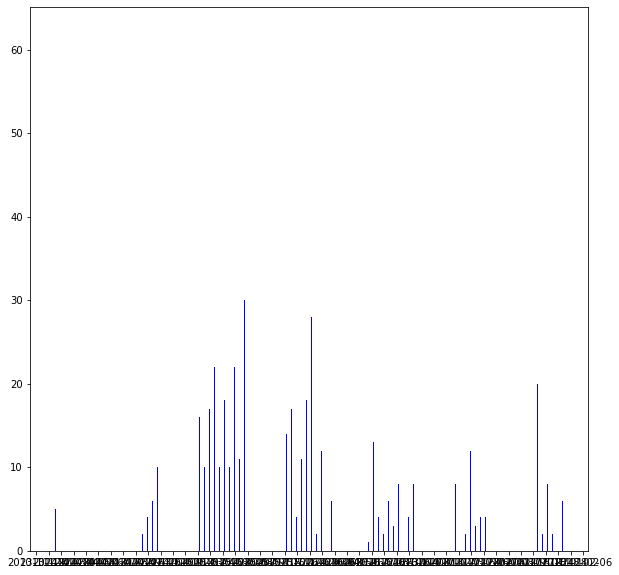

In [ ]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

t=df2.groupby('party')
t.groups.keys()

for i in df2.groupby('party').groups.keys():
  print(i)

  t=df2[df2['party']==i]

  fig, ax = plt.subplots(figsize=(10, 10))

  # Add x-axis and y-axis
  ax.bar(t['date'].values,
        t['count'],
        color='blue')

  # Ensure a major tick for each week using (interval=1) 
  ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=5))

  plt.show()